In [1]:
import math
import os
import sys
sys.path.insert(0,'..')
from src.utilities import DataHandler, FileHandler
from matplotlib import ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns

In [2]:
os.makedirs(FileHandler.FIGURES_DIRECTORY, exist_ok=True)

# Evaluation Data
---

In [3]:
evaluation_summary = DataHandler.get_evaluation_summary()

# time series
timestamps = FileHandler.get_settings()['citylearn']['timestamps']
timestamps = pd.date_range(*tuple(timestamps.values()), freq='H')
carbon_intensity_data = pd.read_csv(os.path.join(FileHandler.SCHEMA_DIRECTORY, 'carbon_intensity.csv'))
pricing_data = pd.read_csv(os.path.join(FileHandler.SCHEMA_DIRECTORY, 'pricing.csv'))
data_list = []

for k, v in evaluation_summary.items():
    for i, evaluation in enumerate(v['evaluations']):
        data = pd.DataFrame(evaluation['time_series'])
        data['simulation_id'] = v['simulation_id']
        data['random_seed'] = v['random_seed']
        start_time_step, end_time_step = evaluation['evaluation_episode_time_steps']
        data['timestamp'] = timestamps[start_time_step:end_time_step + 1].tolist()*len(v['buildings'])
        data['carbon_intensity'] = carbon_intensity_data.iloc[start_time_step:end_time_step + 1]['kg_CO2/kWh'].tolist()*len(v['buildings'])
        data['pricing'] = pricing_data.iloc[start_time_step:end_time_step + 1]['Electricity Pricing [$/kWh]'].tolist()*len(v['buildings'])
        data['reward_function_kwargs'] = [v['reward_function_kwargs']]*data.shape[0]
        data['evaluation_index'] = i
        data_list.append(data)

time_series_data = pd.concat(data_list, ignore_index=True)
time_series_data['controller'] = time_series_data['simulation_id'].str.split('-', expand=True)[0]
time_series_data['objective'] = time_series_data['simulation_id'].str.split('-', expand=True)[2]
time_series_data['der'] = time_series_data['simulation_id'].str.split('-', expand=True)[3]

# action
data_list = []

for k, v in evaluation_summary.items():
    for i, evaluation in enumerate(v['evaluations']):
        for j, a in enumerate(evaluation['actions']):
            data = pd.DataFrame(a)
            data = data.astype(float)
            data['time_step'] = j + 1
            data['bldg_name'] = [f'Building_{i+1}' for i in v['buildings']]
            data['simulation_id'] = v['simulation_id']
            data['evaluation_index'] = i
            data_list.append(data)

action_data = pd.concat(data_list, ignore_index=True)
time_series_data = time_series_data.merge(action_data, on=['simulation_id', 'evaluation_index', 'bldg_name', 'time_step'], how='left')
max_evaluation_index = time_series_data['evaluation_index'].max()
display(time_series_data.head(3))

,bldg_name,net_electricity_consumption,net_electricity_consumption_cost,net_electricity_consumption_emission,net_electricity_consumption_without_storage,net_electricity_consumption_without_storage_and_partial_load,net_electricity_consumption_without_storage_and_partial_load_and_pv,indoor_dry_bulb_temperature,indoor_dry_bulb_temperature_without_partial_load,indoor_dry_bulb_temperature_set_point,...,cooling_cop,controller,objective,der,cooling_storage_action,heating_storage_action,dhw_storage_action,electrical_storage_action,cooling_device_action,heating_device_action
0,Building_2,0.187333,0.005420,0.075399,0.187333,0.187333,0.187333,24.278513,24.278513,24.444445,...,NaN,rlc,peak,ess_pv,NaN,NaN,NaN,NaN,NaN,NaN
1,Building_2,0.185918,0.005379,0.071137,0.185918,0.185918,0.185918,24.264734,24.264734,24.444445,...,NaN,rlc,peak,ess_pv,NaN,NaN,NaN,-0.695643,NaN,NaN
2,Building_2,0.184616,0.005341,0.068208,0.184616,0.184616,0.184616,24.214113,24.214113,24.444445,...,NaN,rlc,peak,ess_pv,NaN,NaN,NaN,-0.682977,NaN,NaN


## Temporary remapping of simulation IDs to match nomenclature in paper

In [4]:
replacement_dict = {
    'no_control': 'x',
    'no_objective': 'x',
    'no_der': 'x',
    'b2': 'b1_b2',
    'cost': 'c',
    'emission': 'e',
    'discomfort': 'd',
    'consumption': 'o',
    'peak': 'p',
    'ess': 'bess'
}
simulation_id_label = time_series_data.groupby('simulation_id').size().reset_index()
simulation_id_label['simulation_id_label'] = simulation_id_label['simulation_id'].tolist()
simulation_id_label['simulation_id_label'] = simulation_id_label['simulation_id_label'].map(lambda x: '-'.join(x.split('-')[:-1]))

for k, v in replacement_dict.items():
    simulation_id_label['simulation_id_label'] = simulation_id_label['simulation_id_label'].str.replace(k, v)

time_series_data = time_series_data.merge(simulation_id_label[['simulation_id', 'simulation_id_label']], on='simulation_id', how='left')

# Baseline Profiles
---

Building_2


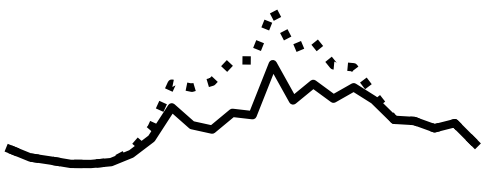

Building_3


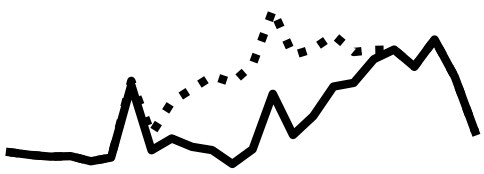

In [5]:
plot_data = time_series_data[
    (time_series_data['simulation_id_label']=='x-b1_b2-x-pv')
    &(time_series_data['evaluation_index']==0)
].copy()
plot_data['hour'] = plot_data['timestamp'].dt.hour
plot_data = plot_data.groupby(['bldg_name', 'hour'])[[
    'net_electricity_consumption_without_storage_and_partial_load',
    'net_electricity_consumption_without_storage_and_partial_load_and_pv',
]].mean().reset_index()

for b, bdata in plot_data.groupby('bldg_name'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    y1 = bdata['net_electricity_consumption_without_storage_and_partial_load'].tolist()
    y2 = bdata['net_electricity_consumption_without_storage_and_partial_load_and_pv'].tolist()
    ax.plot(y1, color='black', clip_on=False, linewidth=6)
    ax.plot(y2, color='black', clip_on=False, linewidth=6, linestyle=':')
    ax.margins(0)
    # display(bdata)
    ax.axis(False)
    plt.savefig(os.path.join(FileHandler.FIGURES_DIRECTORY, f'{b.lower()}_average_daily_profile.pdf'), bbox_inches='tight', transparent=False,)
    print(b)
    plt.show()

# Carbon Intensity Time Series
---

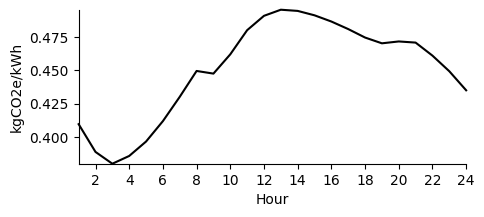

In [6]:
plot_data = time_series_data[
    (time_series_data['evaluation_index']==0)
    &(time_series_data['simulation_id_label']=='x-b1_b2-x-pv')
].copy()
plot_data['hour'] = plot_data['timestamp'].dt.hour
plot_data = plot_data.groupby(['hour'])[['carbon_intensity',]].mean().reset_index()
plot_data.loc[plot_data['hour']==0, 'hour'] = 24
plot_data = plot_data.sort_values('hour')
fig, ax = plt.subplots(1, 1, figsize=(5, 2.0))
x = plot_data['hour'].tolist()
y = plot_data['carbon_intensity'].tolist()
ax.plot(x, y, color='black', clip_on=False)
ax.margins(0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Hour')
ax.set_ylabel('kgCO2e/kWh')
plt.savefig(os.path.join(FileHandler.FIGURES_DIRECTORY, f'carbon_intensity_profile.pdf'), bbox_inches='tight', transparent=False,)
plt.show()

# Emissions and Cost comparison across different DER combinations and control
---

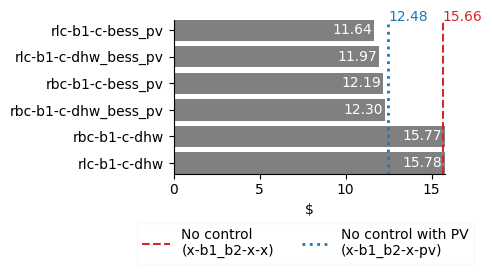

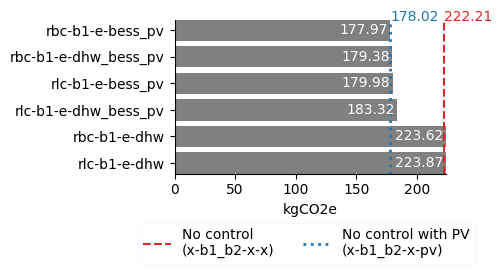

In [7]:
plot_data = time_series_data[
    (time_series_data['evaluation_index']==max_evaluation_index)
    &(time_series_data['bldg_name']=='Building_2')
].copy()

for c, l in zip(['cost', 'emission'], ['$', 'kgCO2e']):
    column = f'net_electricity_consumption_{c}'
    baseline_without_pv = plot_data[plot_data['simulation_id_label']=='x-b1_b2-x-x'][column].sum()
    baseline_with_pv = plot_data[plot_data['simulation_id_label']=='x-b1_b2-x-pv'][column].sum()
    cdata = plot_data[plot_data['objective']==c].copy()
    cdata = cdata.groupby(['simulation_id_label'])[[column]].sum().reset_index()
    cdata = cdata.sort_values(column)
    fig, ax = plt.subplots(1, 1 , figsize=(3.5, 2))
    sns.barplot(x=column, y='simulation_id_label', data=cdata, order=cdata['simulation_id_label'].tolist(), color='grey', ax=ax)
    ax.axvline(baseline_without_pv, color='tab:red', linestyle='--', label='No control\n(x-b1_b2-x-x)')
    ax.text(baseline_without_pv, ax.get_ylim()[1], f'{baseline_without_pv:0.2f}', ha='left', va='center', color='tab:red')
    ax.axvline(baseline_with_pv, color='tab:blue', linestyle=':', linewidth=2.0, label='No control with PV\n(x-b1_b2-x-pv)')
    ax.text(baseline_with_pv, ax.get_ylim()[1], f'{baseline_with_pv:0.2f}', ha='left', va='center', color='tab:blue')
    ax.set_xlabel(l)
    ax.set_ylabel(None)
    ax.legend(
        loc='upper left', 
        bbox_to_anchor=(0.0, -0.1),
        bbox_transform=fig.transFigure,
        framealpha=0.1,
        ncol=2
    )
    ax.margins(0)

    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()*0.99, p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='right', va='center', color='white')

    ax.spines[['right','top']].set_visible(False)
    plt.savefig(os.path.join(FileHandler.FIGURES_DIRECTORY, f'{c}_comparison.pdf'), bbox_inches='tight', transparent=False,)
    plt.show()

# SOC and action time series
---

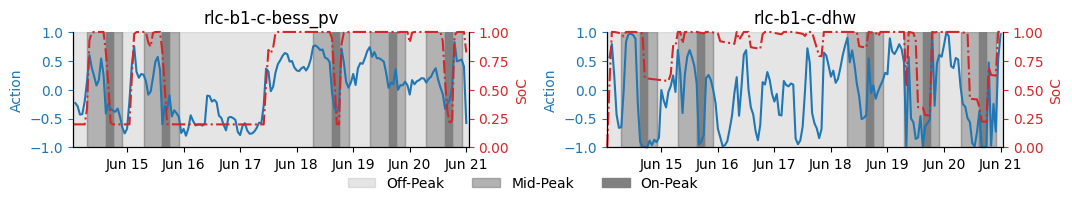

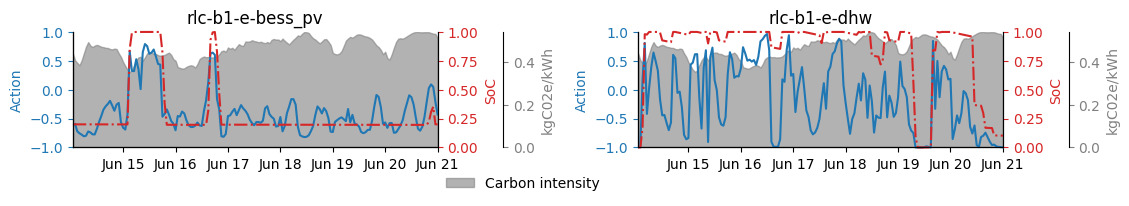

In [8]:
pricing = sorted(time_series_data['pricing'].unique().tolist())
pricing_names = ['Off-Peak', 'Mid-Peak', 'On-Peak']
pricing_alphas = [0.2, 0.6, 1.0]
column_count_limit = 2
plot_data = time_series_data[
    (time_series_data['evaluation_index']==max_evaluation_index)
    &(time_series_data['bldg_name']=='Building_2')
    &(time_series_data['objective'].isin(['cost', 'emission']))
    &(time_series_data['der'].isin(['dhw', 'ess_pv']))
    &(time_series_data['controller'].isin(['rlc']))
].copy()
start_index, end_index = 0, int(7*24)

for o, odata in plot_data.groupby('objective'):
    simulation_ids = odata['simulation_id_label'].unique()
    row_count = math.ceil(len(simulation_ids)/column_count_limit)
    column_count = min(column_count_limit, len(simulation_ids))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 1.5*row_count), sharex=True, gridspec_kw={
        'wspace': 0.55 if o == 'emission' else 0.35, 
        'hspace': 0.4
    })
    handles = []
    labels = []

    for i, (ax, ((e, s, d), sdata)) in enumerate(zip(fig.axes, odata.groupby(['simulation_id_label', 'simulation_id', 'der']))):
        sdata['cumsum'] = (sdata['pricing'] != sdata['pricing'].shift()).cumsum()
        sdata['next_timestamp'] = sdata['timestamp'].shift(-1)
        sdata = sdata.iloc[start_index:end_index].copy()
        x = sdata['timestamp']
        ax2 = None
        ax3 = None

        if o == 'cost':
            for (p, _), g_data in sdata.groupby(['pricing', 'cumsum']):
                ix = pricing.index(p)
                ax.fill_betweenx((-1, 1), g_data['timestamp'].min(), g_data['next_timestamp'].max(), color='grey', alpha=pricing_alphas[ix], label=pricing_names[ix])
        else:
            pass

        if o == 'emission' and ax3 is None:
            ax3 = ax.twinx()
            ax3.spines.right.set_position(('axes', 1.18))
            ax3.stackplot(x, [y3], color='grey', alpha=0.6, labels=['Carbon intensity'])
            ax3.margins(0)
            ax3.spines[['top']].set_visible(False)
            ax3.set_ylabel('kgC02e/kWh')
            ax3.yaxis.label.set_color('grey')
            ax3.tick_params(axis='y', colors='grey')
            ax3.set_zorder(1)
        
        else:
            pass

        for t, l in zip(['dhw', 'electrical'], ['DHW TES', 'ESS']):
            if evaluation_summary[s]['env_metadata']['buildings'][0]['action_metadata'][f'{t}_storage']:
                y1 = sdata[f'{t}_storage_action']
                y2 = sdata[f'{t}_storage_soc']
                y3 = sdata['carbon_intensity']
                a, = ax.plot(x, y1, color='tab:blue', linestyle='-', clip_on=False)
                if ax2 is None:
                    ax2 = ax.twinx()
                
                else:
                    pass

                
                ax2.plot(x, y2, linestyle='-.', color='tab:red', clip_on=False)

            else:
                pass
        
        ax.set_ylim(-1.0, 1.0)
        ax2.set_ylim(0.0, 1.0)
        ax.set_title(e)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.set_zorder(2)
        ax2.set_zorder(3)
        ax.patch.set_visible(False)
        ax.margins(0)
        ax2.margins(0)
        ax.spines[['top']].set_visible(False)
        ax2.spines[['top']].set_visible(False)
        ax.set_ylabel('Action')
        ax2.set_ylabel('SoC')
        ax.yaxis.label.set_color('tab:blue')
        ax2.yaxis.label.set_color('tab:red')
        ax.tick_params(axis='y', colors='tab:blue')
        ax2.tick_params(axis='y', colors='tab:red')

        h, l = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()

        if ax3 is not None:
            h3, l3 = ax3.get_legend_handles_labels()
        else:
            h3, l3 = [], []
            
        handles += h + h2 + h3 
        labels += l + l2 + l3

    unique_handles = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(bbox_to_anchor=(0.5, 0), loc='upper center', bbox_transform=fig.transFigure, framealpha=0, ncol=8, *zip(*unique_handles))      
    plt.savefig(os.path.join(FileHandler.FIGURES_DIRECTORY, f'{o}_soc_action_time_series.pdf'), bbox_inches='tight', transparent=False)
    plt.show()

# Balancing comfort and consumption
---

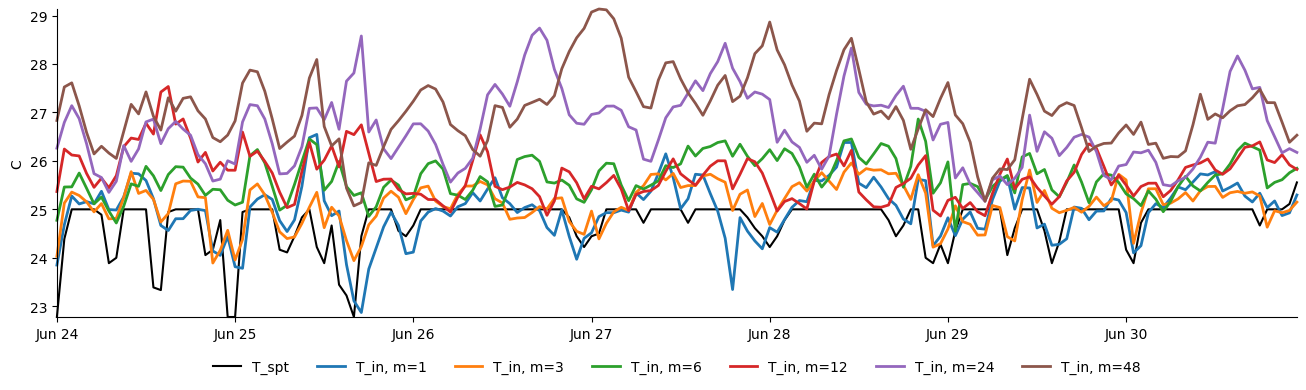

electricity_consumption          \
                                                                 mean     sum   
simulation_id                      multiplier                                   
rlc-b1-discomfort-hp-0             1.0                           0.95  384.77   
rlc-b1-discomfort_consumption-hp-0 3.0                           0.92  373.01   
rlc-b1-discomfort_consumption-hp-1 6.0                           0.87  352.52   
rlc-b1-discomfort_consumption-hp-2 12.0                          0.83  338.13   
rlc-b1-discomfort_consumption-hp-3 24.0                          0.76  309.20   
rlc-b1-discomfort_consumption-hp-4 48.0                          0.73  297.49   

                                                     \
                                                std   
simulation_id                      multiplier         
rlc-b1-discomfort-hp-0             1.0         0.82   
rlc-b1-discomfort_consumption-hp-0 3.0         0.81   
rlc-b1-discomfort_consumption-hp-1 6.0         0.80   
rlc-b1-discomfort_consumption-hp-2 12.0        0.78   
rlc-b1-discomfort_consumption-hp-3 24.0        0.77   
rlc-b1-discomfort_consumption-hp-4 48.0        0.77   

                                              net_electricity_consumption_cost  \
                                                                          mean   
simulation_id                      multiplier                                    
rlc-b1-discomfort-hp-0             1.0                                    0.03   
rlc-b1-discomfort_consumption-hp-0 3.0                                    0.03   
rlc-b1-discomfort_consumption-hp-1 6.0                                    0.03   
rlc-b1-discomfort_consumption-hp-2 12.0                                   0.03   
rlc-b1-discomfort_consumption-hp-3 24.0                                   0.02   
rlc-b1-discomfort_consumption-hp-4 48.0                                   0.02   

                                                            \
                                                 sum   std   
simulation_id                      multiplier                
rlc-b1-discomfort-hp-0             1.0         12.62  0.03   
rlc-b1-discomfort_consumption-hp-0 3.0         12.12  0.03   
rlc-b1-discomfort_consumption-hp-1 6.0         11.40  0.03   
rlc-b1-discomfort_consumption-hp-2 12.0        10.96  0.03   
rlc-b1-discomfort_consumption-hp-3 24.0         9.91  0.02   
rlc-b1-discomfort_consumption-hp-4 48.0         9.59  0.02   

                                              net_electricity_consumption_emission  \
                                                                              mean   
simulation_id                      multiplier                                        
rlc-b1-discomfort-hp-0             1.0                                        0.44   
rlc-b1-discomfort_consumption-hp-0 3.0                                        0.42   
rlc-b1-discomfort_consumption-hp-1 6.0                                        0.40   
rlc-b1-discomfort_consumption-hp-2 12.0                                       0.38   
rlc-b1-discomfort_consumption-hp-3 24.0                                       0.35   
rlc-b1-discomfort_consumption-hp-4 48.0                                       0.34   

                                                            absolute_delta  \
                                                  sum   std           mean   
simulation_id                      multiplier                                
rlc-b1-discomfort-hp-0             1.0         178.59  0.38           0.50   
rlc-b1-discomfort_consumption-hp-0 3.0         172.47  0.37           0.48   
rlc-b1-discomfort_consumption-hp-1 6.0         163.16  0.37           0.78   
rlc-b1-discomfort_consumption-hp-2 12.0        156.48  0.36           0.98   
rlc-b1-discomfort_consumption-hp-3 24.0        142.67  0.35           1.54   
rlc-b1-discomfort_consumption-hp-4 48.0        137.72  0.35           1.99   

                                            

In [9]:
simulation_ids = [
    'rlc-b1-discomfort-hp-0',
    'rlc-b1-discomfort_consumption-hp-0',
    'rlc-b1-discomfort_consumption-hp-1',
    'rlc-b1-discomfort_consumption-hp-2',
    'rlc-b1-discomfort_consumption-hp-3',
    'rlc-b1-discomfort_consumption-hp-4',
]
plot_data = time_series_data[
    (time_series_data['evaluation_index']==max_evaluation_index)
    &(time_series_data['bldg_name']=='Building_2')
    &time_series_data['simulation_id'].isin(simulation_ids)
].copy()
plot_data['multiplier'] = plot_data['reward_function_kwargs'].map(lambda x: 1.0 if x is None else x.get('multiplier', 1.0))
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plot_set_point = False
start_index = -int(7*24)
end_index = int(plot_data['time_step'].max() + 1)

for i, ((s, m), mdata) in enumerate(plot_data.groupby(['simulation_id', 'multiplier'])):
    mdata = mdata.iloc[start_index:end_index].copy()
    x = mdata['timestamp']
    y1 = mdata['indoor_dry_bulb_temperature_set_point']
    y2 = mdata['indoor_dry_bulb_temperature']

    if not plot_set_point:
        ax.plot(x, y1, label='T_spt', color='black', clip_on=False)
        plot_set_point = True
    else:
        pass

    ax.plot(x, y2, label=f'T_in, m={int(m)}', linewidth=2, clip_on=False)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('C')
ax.margins(0)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', framealpha=0, ncol=8,)
plt.show()

plot_data['electricity_consumption'] = plot_data['net_electricity_consumption'].clip(lower=0)
plot_data['delta'] = plot_data['indoor_dry_bulb_temperature'] - plot_data['indoor_dry_bulb_temperature_set_point']
plot_data['absolute_delta'] = plot_data['delta'].abs()
plot_data['too_cold_delta'] = plot_data['delta']
plot_data.loc[plot_data['delta']>=0.0, 'too_cold_delta'] = None
plot_data['too_hot_delta'] = plot_data['delta']
plot_data.loc[plot_data['delta']<=0.0, 'too_hot_delta'] = None
deltas = [1, 2, 3, 4]
delta_columns = []

for d in deltas:
    for m in ['cold', 'hot']:
        delta_column = f'too_{m}_delta_{d}'
        delta_columns.append(delta_column)
        plot_data[delta_column] = 0
        plot_data.loc[plot_data[f'too_{m}_delta'].abs() > d, delta_column] = 1

plot_data = plot_data.groupby(['simulation_id', 'multiplier'])[[
    'electricity_consumption', 'net_electricity_consumption_cost', 'net_electricity_consumption_emission', 
    'absolute_delta', 'too_cold_delta', 'too_hot_delta'
]].agg(['mean', 'sum', 'std'])
plot_data = plot_data.abs().round(2)
display(plot_data)

# District peak reduction
---

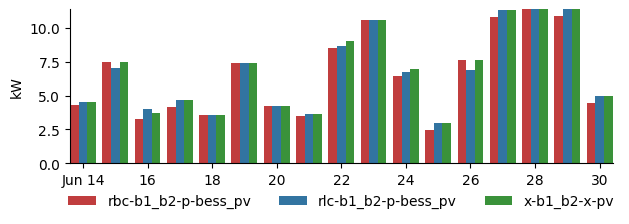

In [10]:
plot_data = time_series_data[
    (time_series_data['bldg_name'].isin(['Building_2', 'Building_3']))
    &(time_series_data['evaluation_index']==max_evaluation_index)
    &time_series_data['simulation_id'].isin(['rbc-b2-peak-ess_pv-0', 'rlc-b2-peak-ess_pv-10', 'no_control-b2-no_objective-pv-0'])
].copy()
plot_data['electricity_consumption'] = plot_data['net_electricity_consumption'].tolist()
plot_data = plot_data.groupby(['simulation_id_label', 'timestamp'])[['electricity_consumption']].sum().reset_index()
plot_data['date'] = plot_data['timestamp'].dt.normalize()
plot_data = plot_data.groupby(['simulation_id_label', 'date'])[['electricity_consumption']].max().reset_index()
plot_data['date'] = plot_data['date'].map(lambda x: x.strftime('%b %d') if x==plot_data['date'].min() else x.strftime('%d'))
fig, ax = plt.subplots(1, 1, figsize=(7, 2))
colors = ['tab:red', 'tab:blue', 'tab:green']
dates = plot_data['date'].unique()
a = sns.barplot(x='date', y='electricity_consumption', data=plot_data, hue='simulation_id_label', palette={s: c for s, c in zip(plot_data['simulation_id_label'].unique(), colors)}, ax=ax)
ax.set_ylabel('kW')
ax.set_xlabel(None)
ax.margins(0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.spines[['right','top']].set_visible(False)
ax.legend(title=None, framealpha=0, bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=3,)
plt.savefig(os.path.join(FileHandler.FIGURES_DIRECTORY, f'daily_peak.pdf'), bbox_inches='tight', transparent=False,)
plt.show()

In [22]:
# edata = plot_data.pivot(index='date', columns='simulation_id_label', values='electricity_consumption')
# edata['b-rbc-diff'] = edata['rbc-b1_b2-p-bess_pv'] - edata['x-b1_b2-x-pv']
# edata['b-rlc-diff'] = edata['rlc-b1_b2-p-bess_pv'] - edata['x-b1_b2-x-pv']
# edata['rbc-rlc-diff'] = edata['rbc-b1_b2-p-bess_pv'] - edata['rlc-b1_b2-p-bess_pv']
# edata['b-rbc-diff-p'] = edata['b-rbc-diff']/edata['x-b1_b2-x-pv']
# edata['b-rlc-diff-p'] = edata['b-rlc-diff']/edata['x-b1_b2-x-pv']
# edata['rbc-rlc-diff-p'] = edata['rbc-rlc-diff']/edata['rlc-b1_b2-p-bess_pv']
# edata[edata['rlc-b1_b2-p-bess_pv']<edata['rbc-b1_b2-p-bess_pv']]['b-rlc-diff-p'].shape